# Explore the FFT analysis of the recorded waveforms
This notebook explores the discrete Fourier analysis of the source audio files.

Author: Reece Robinson, 2016

In [4]:
source_directory = r'/Users/reecerobinson/Library/Mobile Documents/com~apple~CloudDocs/Data Sets/Audio Recognition/Washing Machine Completion/example/'

In [5]:
%matplotlib inline
import seaborn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display

In [6]:
x, sr = librosa.load(source_directory+'161225-002-Beeps.wav', sr=16000)
print x.shape
print sr

(69534,)
16000


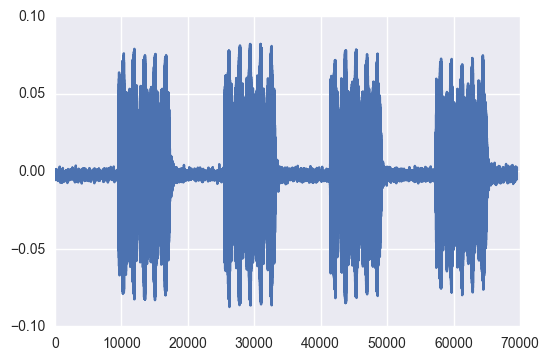

In [7]:
plt.plot(x)
plt.show()

In [8]:
from IPython.display import Audio
Audio(source_directory+'161225-002-Beeps.wav')

In [9]:
x, sr = librosa.load(source_directory+'161225-002-Beep.wav', sr=16000)
print x.shape
print sr

(21334,)
16000


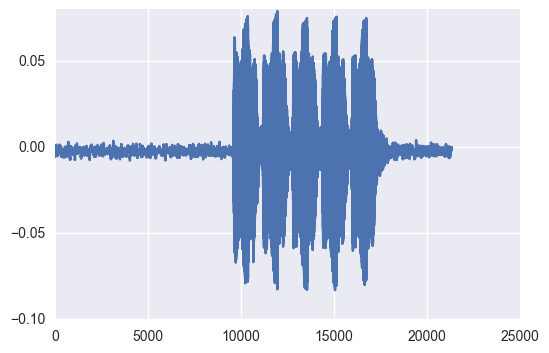

In [10]:
plt.plot(x)
plt.show()

In [11]:
from IPython.display import Audio
Audio(source_directory+'161225-002-Beep.wav')

### Spectogram

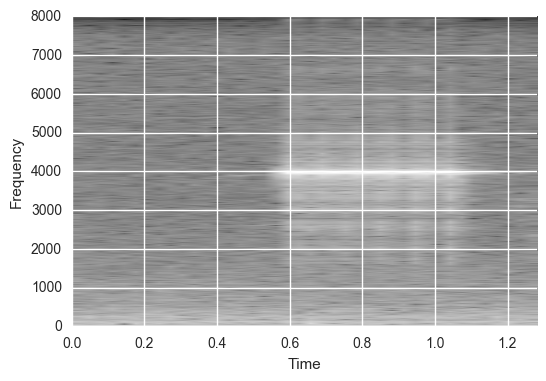

In [12]:
S, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=sr, noverlap=512,cmap=plt.cm.gray)
# S, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=sr, noverlap=512,cmap=plt.cm.gist_heat)

# Plot a spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim(0,8000)
plt.xlim(0,1.28)
plt.show()

### Configure the FFT algorithm for use across the audio signal


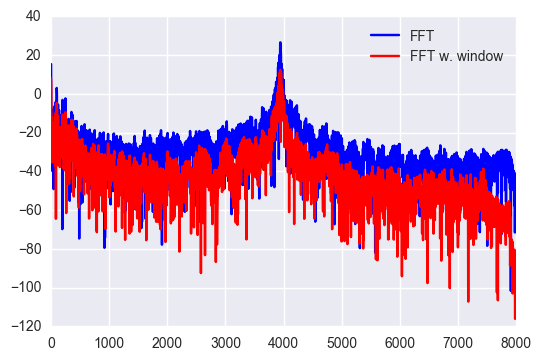

In [13]:
from scipy.fftpack import rfft
from scipy.signal import blackman

duration = 0.15 # window length in seconds
offset=0.5 # test location where there is a signal
sampling_rate=16000
x, sr = librosa.load(source_directory+'161225-002-Beeps.wav', sr=sampling_rate, offset=offset, duration=duration)
N = len(x)
w = blackman(N)
T = 1.0/sampling_rate
FFTw = abs(rfft(x*w))
FFT = abs(rfft(x))
FFTdB = 20*scipy.log10(FFT)
FFTwdB = 20*scipy.log10(FFTw)
freqs = np.linspace(0.0, 1.0/(2.0*T), N)
plt.plot(freqs, FFTdB, c='b')
plt.plot(freqs, FFTwdB, c='r')
plt.legend(['FFT', 'FFT w. window'])
plt.show()

# Create Dataset
### Calculate the FFT for the entire signal in 150 msec sliding window of 5 msec increments
The dataset is a **n** x **m** matrix where **n** is the number of observations and **m** is the calculated frequency power output from the FFT algorithm.

Multiple beep example:

In [14]:
duration = 0.15 # window length in seconds
sampling_rate = 16000
stride = 0.005 # 5 msec sliding window
filename = '161225-002-Beeps.wav'
results = np.array([])
# load the file to get the length in seconds
x_all, sr = librosa.load(source_directory+filename, sr=sampling_rate)
Audio(x_all, rate=sampling_rate)

In [15]:
count = 0
for i in np.arange(0,(float(len(x_all))/sampling_rate)-duration,stride):
    offset = i # seconds
    x, sr = librosa.load(source_directory+'161225-002-Beeps.wav', sr=sampling_rate, offset=offset, duration=duration)
    N = len(x)
    w = blackman(N)
    FFTw = abs(rfft(x*w))
    FFTwdB = 20*scipy.log10(FFTw)
    # build the result matrix
    if i == 0:
        results = np.array(FFTwdB)
    else:
        results = np.vstack((results, FFTwdB))

T = 1.0/sampling_rate
freqs = np.linspace(0.0, 1.0/(2.0*T), N)
print(results.shape)

np.savetxt('161225-002-Beeps-fft-numpy.csv',results,delimiter=',')

(840, 2400)


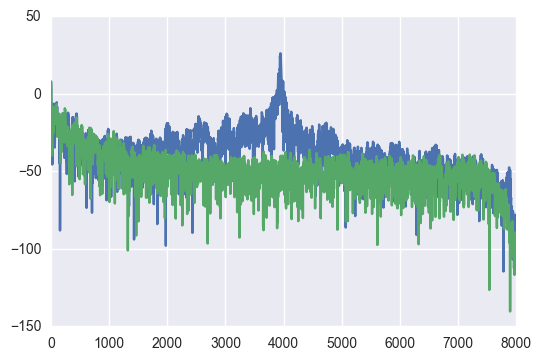

In [16]:
# Test plot to verify the resuts are as expected
plt.plot(freqs,results[153])
plt.plot(freqs,results[10])
plt.show()

# Create the labels for the observations

In [17]:
import pandas as pd
df = pd.DataFrame(results)

# Ignore the first section of the frequencies as these are not relevant 
# and have relatively large values compared with the signal of interest.

cols = np.arange(300,2400)
sub_df = df.iloc[:,cols]

### Observations with power values over -0.5 dB are assigned a True Positive Response

In [18]:
df['response'] =(sub_df.loc[:,cols-300].max(axis=1) > -0.5)
df['response'].value_counts()

True     458
False    382
Name: response, dtype: int64

### Verify that the selected observations have a peak for the beep frequency.

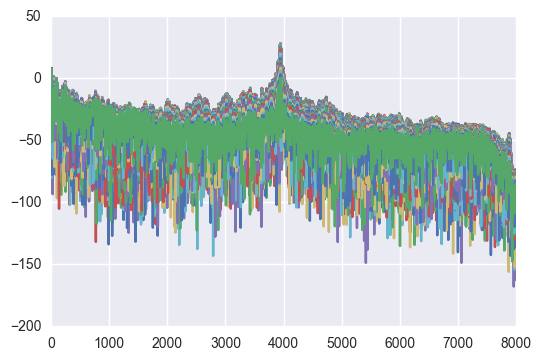

In [19]:
plt.plot(freqs,df[df['response'] == True].drop('response',axis=1).T)
plt.show()

# Output Training Data

In [20]:
positive_label_data = df[df['response'] == True].drop('response',axis=1)
print (positive_label_data.shape)

# Positive Samples
sample_size = 2400
w_size = 80
for idx in positive_label_data.index:
    begin = idx * w_size 
    librosa.output.write_wav('positive_sample_%s.wav'%idx,x_all[begin:begin+sample_size], sampling_rate)

df.to_csv(source_directory+'161225-002-Beeps-fft-training.csv', header=True, index=False)

(458, 2400)
